# Brain Tumor Segmentation using U-Net architecture.
  U-Net Official paper : [Submitted on 18 May 2015 to arxiv.org](https://arxiv.org/abs/1505.04597)<br>
  Dataset Used : [Submitted on 03 April 2017 by Jun Cheng](https://figshare.com/articles/brain_tumor_dataset/1512427)<br>
  Primary Deeplearning Framework Used: [Pytorch by Facebook AI](https://pytorch.org/)
  
  Contents:<br>
  - [Library Imports](#Library-Imports)
  - [Hyperparameters Tuning](#Hyperparameters-Tuning)
  - [Dataset Loading](#Dataset-Loading)
  - [Model Declaration](#Model-Declaration)
  - [Model Training](#Model-Training)
  - [Training Results](#Training-Results)
      - [Training Loss Graph](#Training-Loss-Graph)
      - [Prediction Visualization](#Visualize-Test-Dataset-Predictions)

## Library Imports

In [16]:
#!pip install -r requirements.txt
#!pip install torch #torch-2.0.1-
#!pip install torchvision #torchvision-0.15.2
#!pip install tqdm #tqdm-4.65.0
#!pip install torchsummary # torchsummary-1.5.1
#!pip install tensorboardX #tensorboardX-2.6
#!pip install requests
#!Pillow #9.5.0
#!pip install numpy #1.24.3
!pip freeze requirements2.txt

anyio @ file:///tmp/build/80754af9/anyio_1644463572971/work/dist
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///tmp/build/80754af9/argon2-cffi-bindings_1644569679365/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
attrs @ file:///croot/attrs_1668696182826/work
Babel @ file:///croot/babel_1671781930836/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
beautifulsoup4 @ file:///croot/beautifulsoup4-split_1681493039619/work
bleach @ file:///opt/conda/conda-bld/bleach_1641577558959/work
brotlipy==0.7.0
certifi @ file:///croot/certifi_1683875369620/work/certifi
cffi @ file:///croot/cffi_1670423208954/work
charset-normalizer @ file:///tmp/build/80754af9/charset-normalizer_1630003229654/work
cmake==3.26.3
comm @ file:///croot/comm_1671231121260/work
contourpy==1.0.7
cryptography @ file:///croot/cryptography_1677533068310/work
cycler==0.11.0
debugpy @ file:///tmp/build/80754af9/debugpy_163709

In [2]:
import os
import warnings
import pickle
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import SubsetRandomSampler

import numpy as np
%matplotlib inline

import bts.dataset as dataset
import bts.model as model
import bts.classifier as classifier
import bts.plot as plot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')

# To Start TensorBoard
# tensorboard --logdir logs --samples_per_plugin images=200

Computation Details
	Device Used: (cuda)  NVIDIA RTX A1000 Laptop GPU

Packages Used Versions:-
	Pytorch Version: 2.0.1+cu117


## Hyperparameters Tuning 

In [4]:
# Dataset part used for testing
TEST_SPLIT = 0.2
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6
# Dataset folder used
DATASET_USED = 'png_dataset'
# Full Dataset path
DATASET_PATH = os.path.join('dataset',DATASET_USED)
#DATASET_PATH = os.path.join('setup_scripts/dataset',DATASET_USED)
# Training Epochs
#EPOCHS = 100
EPOCHS = 1
# Filters used in UNet Model
FILTER_LIST = [16,32,64,128,256]
# Flag to train the model
TRAIN = False
# Flag to load saved model
LOAD_MODEL = True
# Flag to save model trained
SAVE_MODEL = False
# Model name to save or load.
MODEL_NAME = f"UNet-{FILTER_LIST}.pt"

print(f"Model Name :   {MODEL_NAME}")

Model Name :   UNet-[16, 32, 64, 128, 256].pt


## Dataset Loading

In [5]:
def get_indices(length, new=False):
    """ Gets the Training & Testing data indices for a
    paticular "DATASET_USED".Stores the indices and returns
    them back when the same dataset is used.
    Parameters:
        length(int): Length of the dataset used.
        new(bool): Discard the saved indices and get new ones.
    Return:
        train_indices(list): Array of indices used for training purpose.
        test_indices(list): Array of indices used for testing purpose.
    """
    # Pickle file location of the indices.
    file_path = os.path.join('dataset',f'split_indices_{DATASET_USED}.p')
    data = dict()
    if os.path.isfile(file_path) and not new:
        # File found.
        with open(file_path,'rb') as file :
            data = pickle.load(file)
            return data['train_indices'], data['test_indices']
    else:
        # File not found or fresh copy is required.
        indices = list(range(length))
        np.random.shuffle(indices)
        split = int(np.floor(TEST_SPLIT * len(tumor_dataset)))
        train_indices , test_indices = indices[split:], indices[:split]
        # Indices are saved with pickle.
        data['train_indices'] = train_indices
        data['test_indices'] = test_indices
        with open(file_path,'wb') as file:
            pickle.dump(data,file)
    return train_indices, test_indices

In [6]:
tumor_dataset = dataset.TumorDataset(DATASET_PATH)

train_indices, test_indices = get_indices(len(tumor_dataset))
train_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(tumor_dataset, BATCH_SIZE, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler=test_sampler)

## Model Declaration

In [7]:
unet_model = None
unet_classifier = None
if not LOAD_MODEL:
    # New model is created.
    unet_model = model.DynamicUNet(FILTER_LIST).to(device)
    unet_classifier = classifier.BrainTumorClassifier(unet_model,device)
else:
    # Saved model is loaded on memory.
    unet_model = model.DynamicUNet(FILTER_LIST)
    unet_classifier = classifier.BrainTumorClassifier(unet_model,device)
    unet_classifier.restore_model(os.path.join('saved_models',MODEL_NAME))
    print('Saved model loaded')

Saved model loaded


#### Uncomment this section if visualization of training progress is required on Tensorboard

In [8]:
"""
till = 8
choice = test_indices[:till]
sample = list()
for _ in range(till):
    sample.append(dataset[choice[_]])
"""

'\ntill = 8\nchoice = test_indices[:till]\nsample = list()\nfor _ in range(till):\n    sample.append(dataset[choice[_]])\n'

## Model Training

In [14]:
# Training process
if TRAIN:
    unet_model.train()
    path = os.path.join('saved_models',MODEL_NAME) if SAVE_MODEL else None
    unet_train_history = unet_classifier.train(EPOCHS,trainloader,mini_batch=100,save_best=path)
    print(f'Training Finished after {EPOCHS} epoches')



In [15]:

# Testing process on test data.
unet_model.eval()
unet_score = unet_classifier.test(testloader)
print(f'\n\nDice Score {unet_score}')
# Dice Score 0.7446110107881675



Dice Score 0.7311597526743217


## Training Results

### Training Loss Graph

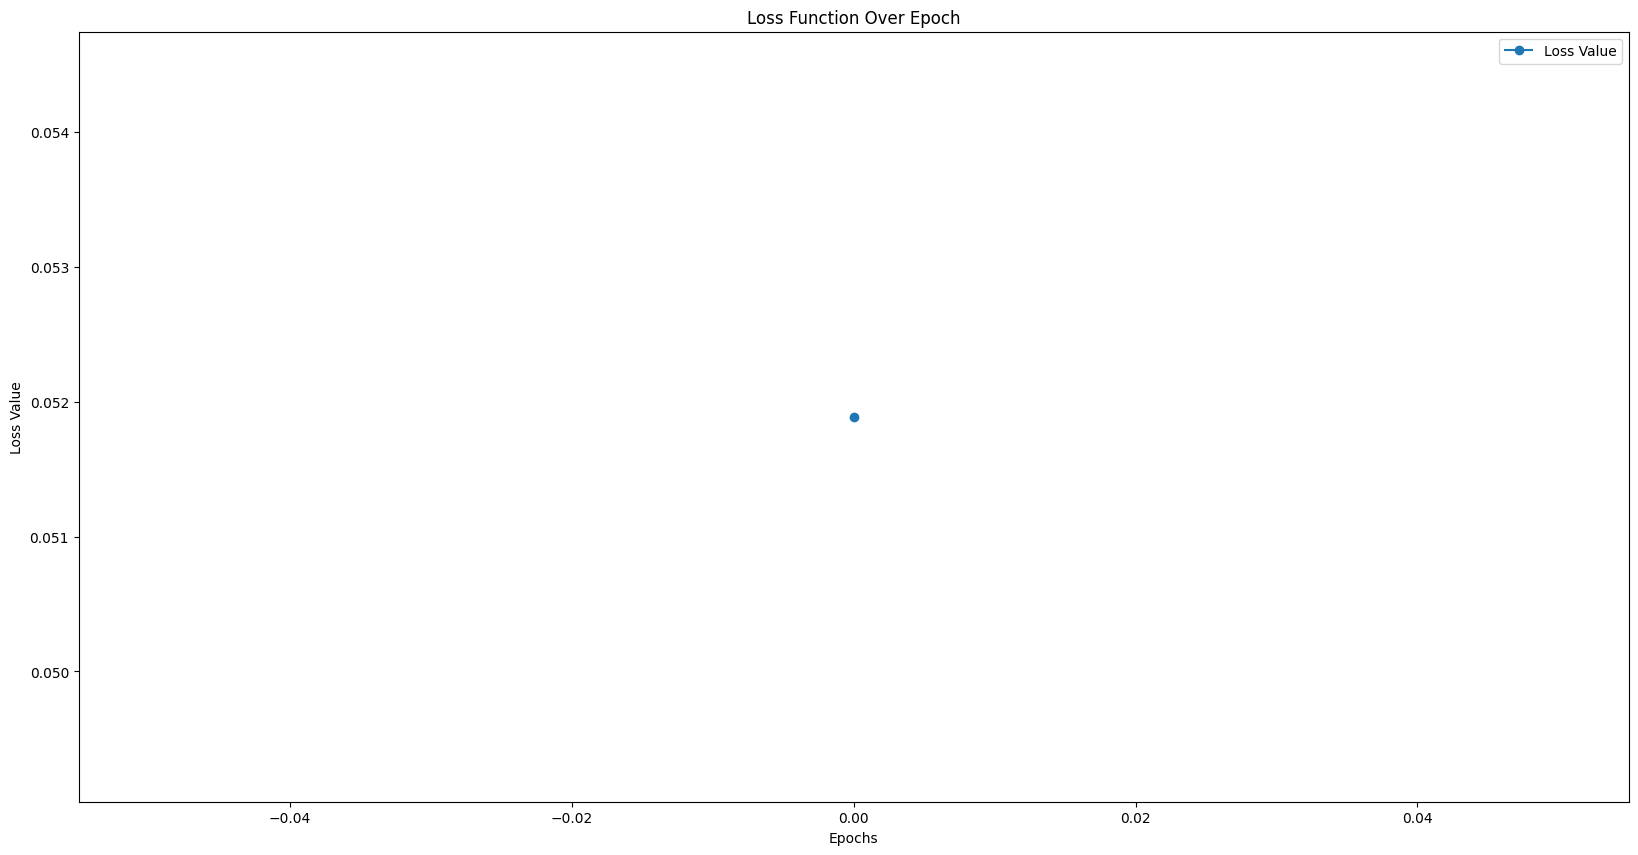

In [11]:
save_plot = os.path.join('images',f'{MODEL_NAME}-loss_graph.png')
plot.loss_graph(unet_train_history['train_loss'],save_plot)

### Visualize Test Dataset Predictions
Run the 2nd cell to get new predictions of different data

In [12]:
i=0

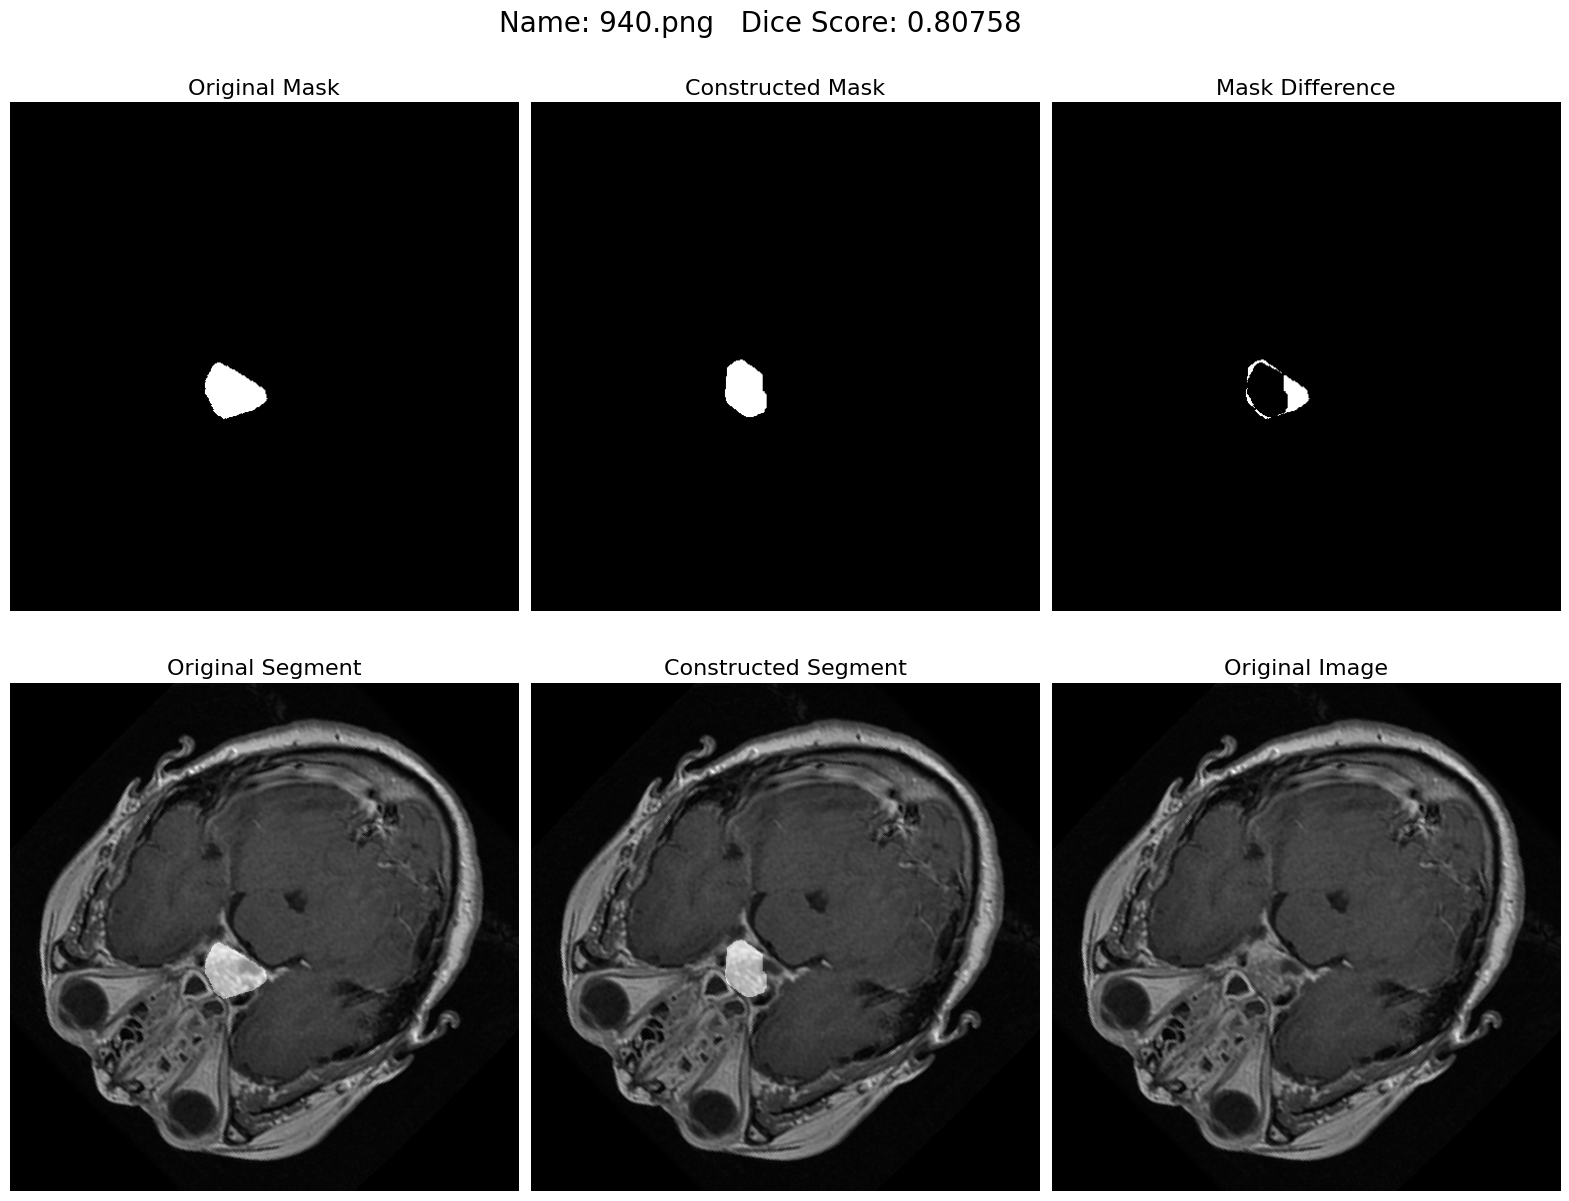

In [13]:
# Run this cell repeatedly to see some results.
image_index = test_indices[i]
sample = tumor_dataset[image_index]
image, mask, output, d_score = unet_classifier.predict(sample,0.65)
title = f'Name: {image_index}.png   Dice Score: {d_score:.5f}'
# save_path = os.path.join('images',f'{d_score:.5f}_{image_index}.png')
plot.result(image,mask,output,title,save_path=None)
i += 1
if i >= len(test_indices):
    i = 0 